# Libs

In [1]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)

2023-04-03 12:35:22.852591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 12:35:22.852615: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Functions

In [3]:
# Construct and fit model.
# @tf.function
def fit_distribution(
    model,
    learning_rate=0.001,
    lr_patience=5,
    monitor="loss",
    **kwds,
):
    set_seed(1)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=lambda y, dist: -dist.log_prob(y),
    )

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor=monitor,
            factor=0.1,
            patience=lr_patience,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor,
            patience=3 * lr_patience,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.TerminateOnNaN(),
    ]

    return model.fit(
        shuffle=True,
        callbacks=callbacks,
        **kwds,
    )

In [4]:
def plot_samples(dist, train_data, seed=1, ax=plt):
    set_seed(seed)
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample((N,))
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(data=df, x="x1", y="x2", hue="source", ax=plt)
    g.plot_joint(sns.kdeplot, zorder=0)
    # g.plot_marginals(sns.rugplot, height=-.15)

# Data

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2023-04-03 12:35:26.753638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 12:35:26.753661: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 12:35:26.753690: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch.microos-tp): /proc/driver/nvidia/version does not exist
2023-04-03 12:35:26.754007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/work/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

## Build a training pipeline

In [7]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

In [8]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

## Build an evaluation pipeline

In [9]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Plot Exampes

In [10]:
it = ds_train.as_numpy_iterator()

In [11]:
x, y = next(it)

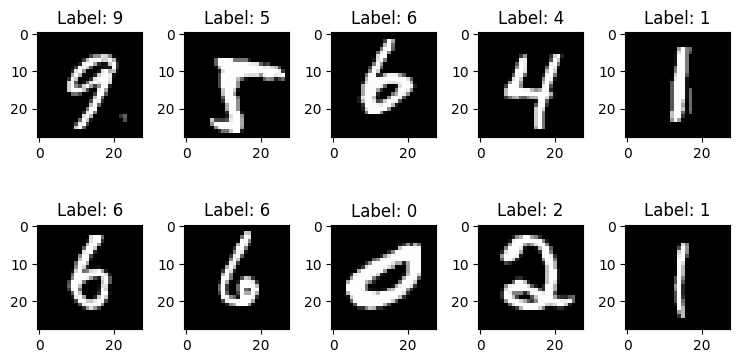

In [12]:
num_row = 2
num_col = 5  # plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(x[i], cmap="gray")
    ax.set_title("Label: {}".format(y[i]))
plt.tight_layout()
plt.show()

# Gropp 2022: Iseomtric Autoencoder

High dimensional data is often assumed to be concentrated on or near a low-dimensional manifold. Autoencoders (AE) is a popular technique to learn representations of such data by pushing it through a neural network with a low dimension bottleneck while minimizing a reconstruction error. Using high capacity AE often leads to a large collection of minimizers, many of which represent a low dimensional manifold that fits the data well but generalizes poorly.
Two sources of bad generalization are: extrinsic, where the learned manifold possesses extraneous parts that are far from the data; and intrinsic, where the encoder and decoder introduce arbitrary distortion in the low dimensional parameterization. An approach taken to alleviate these issues is to add a regularizer that favors a particular solution; common regularizers promote sparsity, small derivatives, or robustness to noise.
In this paper, we advocate an isometry (i.e., local distance preserving) regularizer.

Specifically, our regularizer encourages: 

 1. the decoder to be an isometry;

end 

 2. the encoder to be the decoder's pseudo-inverse, that is, the encoder extends the inverse of the decoder to the ambient space by orthogonal projection.
 
In a nutshell, (1) and (2) fix both intrinsic and extrinsic degrees of freedom and provide a non-linear generalization to principal component analysis (PCA). Experimenting with the isometry regularizer on dimensionality reduction tasks produces useful low-dimensional data representations. 

In [13]:
class IAE(tf.keras.Model):
    """
    Isometric Autoencoder (I-AE):
    Original publication: Gropp, Amos, Matan Atzmon, and Yaron Lipman. "Isometric autoencoders." arXiv preprint arXiv:2006.09289 (2020).
    Code written by:
        - Felix Rauh (FZJ: IEK-10, RWTH)
        - Eike Cramer (FZJ: IEK-10, RWTH)

    Autoencoding:
        z = g(x)
        x = f(z) = f(g(x))

    I-AE enforces an autoencoder with isometric decoding:
        J_{decode}^T * J_{decode} = I,
    and encoder the pseudo inverse of decoder:
        J_{encode} * J_{encode}^T = I.
    """

    def __init__(
        self,
        encoder,
        decoder,
        N_U=20,
        N_Z=20,
        lambda_iso=0.1,
        lambda_piso=0.1,
        name="isometric_ae",
    ):
        super().__init__(name=name)

        # Network set up
        self.encoder = encoder  # g(x)
        self.decoder = decoder  # f(z)

        # Distribution of unit vectors 'u' (assumes 1D latent space)
        self.u_dist = tfd.SphericalUniform(self.encoder.output_shape[-1])

        # hyperparameters
        self.lambda_iso = lambda_iso  # loss function weight iso-loss
        self.lambda_piso = lambda_piso  # loss function weight piso-loss
        self.N_U = N_U  # Number of Monte Carlo samples for expectation over u
        self.N_Z = N_Z  # Number of Monte Carlo samples for expectation over z

        # loss trackers. only to track progress
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.MSEloss_tracker = tf.keras.metrics.Mean(name="MSEloss")
        self.ISOloss_tracker = tf.keras.metrics.Mean(name="ISOloss")
        self.PISOloss_tracker = tf.keras.metrics.Mean(name="PISOloss")

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [
            self.loss_tracker,
            self.MSEloss_tracker,
            self.ISOloss_tracker,
            self.PISOloss_tracker,
        ]

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def fit_and_sample_z(self, z, shape=(1,)):
        loc, scale = tf.nn.moments(z, axes=[0])  # moments over batch
        return tfd.Sample(  # gets dim from dim(loc)
            tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale, validate_args=False),
            sample_shape=shape,
        ).sample()

    def sample_u(self, shape=(1,)):
        return self.u_dist.sample(sample_shape=shape)

    def iso_loss(self, encoding):
        z = self.fit_and_sample_z(
            encoding, shape=(self.N_Z,)
        )  # fits Multivar. Gaussian to encoding and samples
        with tf.GradientTape(
            watch_accessed_variables=False
        ) as IsoTape:  # to get Jacobian of f
            IsoTape.watch(z)
            z_hat = self.decode(z)  # f: decoding
        jac_f = IsoTape.batch_jacobian(z_hat, z)  # Jacobian of decoding: J_f
        iso_loss = self.Jacobian_Loss(jac_f, 2)
        return tf.reduce_mean(iso_loss)  # axis=2 for last axis for tensordot

    def piso_loss(self, batch):
        """
        Piso Loss should be computed as expectation over Manifold:
            E_M {(||u^T dg(x)||-1)^2} with: x \in Manifold
        Manifold is unknown so we use data instead and combine Piso Loss with encoding step
        """
        with tf.GradientTape(
            watch_accessed_variables=False
        ) as PisoTape:  # to get Jacobian of g
            PisoTape.watch(batch)
            encoding = self.encode(batch)  # g: encoding
        jac_g = PisoTape.batch_jacobian(encoding, batch)  # Jacobian of encoding: J_g
        piso_loss = self.Jacobian_Loss(jac_g, 1)  # axis=1 to avoid transpose of 'u'
        return encoding, tf.reduce_mean(piso_loss)  # reduce to 1D for compatibility

    def Jacobian_Loss(self, jac, axis):  # Same for iso and piso
        u = self.sample_u(shape=(self.N_U,))  # Sample new 'u'
        loss = tf.tensordot(
            jac, u, axes=[[axis], [-1]]
        )  # tensorproduct of Jacobian and 'u'
        loss = tf.norm(loss, axis=1)  # norm of tensorproduct: "length"
        return tf.reduce_mean((loss - 1) ** 2, axis=-1)  # mse over "length-1"

    def train_step(self, batch):
        # Overall Gradient taping for all three parts of the loss
        with tf.GradientTape() as Grad_Tape:  # for full loss
            Grad_Tape.watch(self.trainable_variables)
            # Pseudo inverse loss
            encoding, piso_loss = self.piso_loss(batch)
            # MSE Loss
            reconstruction = self.decode(encoding)  # f: decoding
            MSELoss = tf.reduce_mean(
                tf.keras.losses.mean_squared_error(batch, reconstruction)
            )
            # isometry loss
            iso_loss = self.iso_loss(encoding)
            # total loss
            loss = MSELoss + self.lambda_iso * iso_loss + self.lambda_piso * piso_loss

        # Gradients and optimizer
        grad = Grad_Tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))

        # loss tracking
        self.loss_tracker.update_state(loss)
        self.MSEloss_tracker.update_state(MSELoss)
        self.ISOloss_tracker.update_state(iso_loss)
        self.PISOloss_tracker.update_state(piso_loss)
        return {
            "loss": self.loss_tracker.result(),
            "MSEloss": self.MSEloss_tracker.result(),
            "ISOloss": self.ISOloss_tracker.result(),
            "PISOloss": self.PISOloss_tracker.result(),
        }

    def test_step(self, batch):
        # Pseudo inverse loss
        encoding, piso_loss = self.piso_loss(batch)
        # MSE Loss
        reconstruction = self.decode(encoding)  # f: decoding
        MSELoss = tf.reduce_mean(
            tf.keras.losses.mean_squared_error(batch, reconstruction)
        )
        # isometry loss
        iso_loss = self.iso_loss(encoding)
        # total loss
        loss = MSELoss + self.lambda_iso * iso_loss + self.lambda_piso * piso_loss

        # loss tracking
        self.loss_tracker.update_state(loss)
        self.MSEloss_tracker.update_state(MSELoss)
        self.ISOloss_tracker.update_state(iso_loss)
        self.PISOloss_tracker.update_state(piso_loss)
        return {
            "loss": self.loss_tracker.result(),
            "MSEloss": self.MSEloss_tracker.result(),
            "ISOloss": self.ISOloss_tracker.result(),
            "PISOloss": self.PISOloss_tracker.result(),
        }

In [14]:
class IAE2D(IAE):
    """
    The 2D version of the I-AE is almost identical to the 1D version.
    Unit vector norm implementation via reshape of jacobian-tensor to Jacobian matrix.

    For encoder:
    Jac_g = [BATCHDIM, LATENTDIM, DATADIM_1, DATADIM_2]
    Reshape(Jac_g) = [BATCHDIM, LATENTDIM, DATADIM_1*DATADIM_2]

    for decoder:
    Jac_f = [BATCHDIM, DATADIM_1, DATADIM_2, LATENTDIM]
    Reshape(Jac_f) = [BATCHDIM, DATADIM_1*DATADIM_2, LATENTDIM]
    """

    def __init__(
        self, encoder, decoder, N_U=20, N_Z=20, lambda_iso=0.1, lambda_piso=0.1
    ):
        super().__init__(
            encoder,
            decoder,
            N_U=N_U,
            N_Z=N_Z,
            lambda_iso=lambda_iso,
            lambda_piso=lambda_piso,
        )

        self.Reshape_Jac = [
            0,
            tf.keras.layers.Reshape(
                target_shape=(
                    self.encoder.output_shape[-1],
                    self.encoder.input_shape[1] * self.encoder.input_shape[2],
                )
            ),
            tf.keras.layers.Reshape(
                target_shape=(
                    self.decoder.output_shape[1] * self.decoder.output_shape[2],
                    self.decoder.input_shape[-1],
                )
            ),
        ]

    def Jacobian_Loss(self, jac, axis):  # Same for iso and piso
        u = self.sample_u(shape=(self.N_U,))  # Sample new 'u'
        jac = self.Reshape_Jac[axis](jac)  # Reshape of Jacobian to matrix format
        loss = tf.tensordot(
            jac, u, axes=[[axis], [-1]]
        )  # tensorproduct of Jacobian and 'u'
        loss = tf.norm(loss, axis=1)  # norm of tensorproduct: "length"
        loss = tf.math.square(loss - 1.0)
        return tf.reduce_mean(loss, axis=-1)  # mse over "length-1"

## Train I-AE

In [31]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/work/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [15]:
ds_train_images = ds_train.map(lambda x, y: x)

In [39]:
BATCHSIZE = 128
LATENTDIM = 12
datashape = ds_info.features["image"].shape

seed = 1

set_seed(1)

# we use 'tanh' activation because 'relu' often leads to singular jacobians.
activation = "tanh"
# encoder model: g(x)
g = K.Sequential(
    [
        K.layers.InputLayer(input_shape=datashape),
        K.layers.Flatten(),
        K.layers.Dense(LATENTDIM),
    ],
    name="pseudoinverse",
)
# decoder model: f(x)
f = K.Sequential(
    [
        K.layers.InputLayer(input_shape=(LATENTDIM,)),
        K.layers.Dense(units=datashape[0] * datashape[1], activation=activation),
        K.layers.Reshape(datashape),
    ],
    name="isometry",
)

model = IAE2D(g, f)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.fit(ds_train_images, epochs=100)

Epoch 1/100
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


469/469 [==============================] - 70s 144ms/step - loss: 0.0492 - MSEloss: 0.0483 - ISOloss: 0.0058 - PISOloss: 0.0036
Epoch 2/100
469/469 [==============================] - 70s 148ms/step - loss: 0.0345 - MSEloss: 0.0339 - ISOloss: 0.0063 - PISOloss: 3.1811e-05
Epoch 3/100
469/469 [==============================] - 69s 146ms/step - loss: 0.0340 - MSEloss: 0.0333 - ISOloss: 0.0068 - PISOloss: 2.2736e-05
Epoch 4/100
469/469 [==============================] - 69s 147ms/step - loss: 0.0339 - MSEloss: 0.0332 - ISOloss: 0.0068 - PISOloss: 2.5157e-05
Epoch 5/100
469/469 [==============================] - 69s 148ms/step - loss: 0.0338 - MSEloss: 0.0331 - ISOloss: 0.0068 - PISOloss: 2.4878e-05
Epoch 6/100
 99/469 [=====>........................] - ETA: 58s - loss: 0.0338 - MSEloss: 0.0331 - ISOloss: 0.0069 - PISOloss: 2.6575e-05

KeyboardInterrupt: 

In [ ]:
# CONV_B 32,4,2,1
# CONV_B 64,4,2,1
# CONV_B 128,4,2,1
# CONV_B 256,4,2,0
# LIN 2


In [22]:
BATCHSIZE = 128
LATENTDIM = 2
datashape = ds_info.features["image"].shape

seed = 1

set_seed(1)

# we use 'tanh' activation because 'relu' often leads to singular jacobians.
activation = "tanh"
# encoder model: g(x)
g_cnn = K.Sequential(
    [
        K.layers.InputLayer(input_shape=datashape),
        # CONV_B 32,4,2,1
        K.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # CONV_B 64,4,2,1
        K.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # CONV_B 128,4,2,1
        K.layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # CONV_B 256,4,2,0
        K.layers.Conv2D(256, kernel_size=4, strides=2, padding='valid', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # LIN 2
        K.layers.Dense(LATENTDIM, activation='linear'),
        K.layers.Flatten(),
    ],
    name="isometry",
)
# decoder model: f(x)
f_cnn = K.Sequential(
    [
        K.layers.InputLayer(input_shape=(LATENTDIM,)),
        # FC 256
        K.layers.Dense(256),
        K.layers.Activation(activation=tf.math.softplus),
        K.layers.Reshape((1, 1, -1)),
        # CONV_T_B 128,4,2,1
        K.layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding='valid', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # CONV_T_B 64,4,2,1
        K.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='valid', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # CONV_T_B 32,4,2,1
        K.layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
        # CONV_T_B 1,4,2,3
        K.layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='linear'),
        K.layers.BatchNormalization(),
        K.layers.Activation(activation=tf.math.softplus),
    ],
    name="pseudoinverse",
)

In [ ]:
model = IAE2D(g_cnn, f_cnn)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.fit(ds_train_images, epochs=100)

Epoch 1/100


2023-04-03 12:34:27.876307: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 128450560 exceeds 10% of free system memory.
2023-04-03 12:34:27.929604: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 196689920 exceeds 10% of free system memory.
2023-04-03 12:34:28.049522: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 393379840 exceeds 10% of free system memory.
2023-04-03 12:34:28.808474: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 196689920 exceeds 10% of free system memory.
2023-04-03 12:34:29.165696: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 128450560 exceeds 10% of free system memory.


In [20]:
g_cnn.summary()

Model: "isometry"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        544       
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 7, 7, 64)          0  

In [21]:
f_cnn.summary()

Model: "pseudoinverse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 activation_13 (Activation)  (None, 256)               0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4, 4, 128)        524416    
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 4, 4, 128)        512       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 4, 4, 128)       

In [41]:
from datetime import datetime

In [66]:
tf.saved_model.save(model, datetime.now().strftime("%y%m%d_%H%M%S_I-AE.keras"))

INFO:tensorflow:Assets written to: 230403_103846_I-AE.keras/assets


INFO:tensorflow:Assets written to: 230403_103846_I-AE.keras/assets


In [19]:
dims = len(targets)

In [90]:
ds_train_encoded = ds_train.map(lambda x, y: (y, g(x)))
ds_train_encoded = ds_train_encoded.cache()

# Density Model

## Parameter Model

In [67]:
def get_model(input_shape, output_shape, dist_lambda):
    set_seed(1)
    inputs = K.Input(input_shape)
    x = K.layers.Dense(32, activation="relu", name="hidden1")(inputs)
    x = K.layers.Dense(32, activation="relu", name="hidden2")(x)
    pv = K.layers.Dense(output_shape, activation="linear", name="pv")(x)
    dist = tfp.layers.DistributionLambda(dist_lambda)(pv)
    param_model = K.Model(inputs=inputs, outputs=dist)
    param_model.summary()
    return param_model

In [86]:
P = partial(get_model, input_shape=(1,))

## Multivariate Normal

In [87]:
def get_multivariate_normal_lambda(dims):
    def lmbd(pv):
        loc = pv[..., :dims]
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., dims:])
        mv_normal = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        return mv_normal

    return lmbd

In [88]:
mn_model = P(
    output_shape=LATENTDIM + np.sum(np.arange(LATENTDIM + 1)),
    dist_lambda=get_multivariate_normal_lambda(LATENTDIM),
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 hidden1 (Dense)             (None, 32)                64        
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 90)                2970      
                                                                 
 distribution_lambda_1 (Dist  ((None, 12),             0         
 ributionLambda)              (None, 12))                        
                                                                 
Total params: 4,090
Trainable params: 4,090
Non-trainable params: 0
_________________________________________________________

In [91]:
mn_hist = fit_distribution(
    mn_model,
    x=ds_train_encoded,
    # validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.01,
    lr_patience=2,
)

Epoch 1/100
469/469 [==============================] - 4s 4ms/step - loss: 503.9847 - lr: 0.0100
Epoch 2/100
469/469 [==============================] - 2s 4ms/step - loss: 19.4829 - lr: 0.0100
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 19.4756 - lr: 0.0100
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 19.4644 - lr: 0.0100
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 19.4212 - lr: 0.0100
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 19.2122 - lr: 0.0100
Epoch 7/100
469/469 [==============================] - 2s 4ms/step - loss: 18.9327 - lr: 0.0100
Epoch 8/100
469/469 [==============================] - 2s 4ms/step - loss: 18.7127 - lr: 0.0100
Epoch 9/100
469/469 [==============================] - 2s 4ms/step - loss: 18.4042 - lr: 0.0100
Epoch 10/100
469/469 [==============================] - 2s 4ms/step - loss: 18.1398 - lr: 0.0100
Epoch 11/100
469/469 [================

KeyboardInterrupt: 

In [99]:
mn_samples = mn_model(1.0 * tf.ones((1))).sample(10)
mn_samples.shape

TensorShape([10, 1, 12])

In [101]:
samples = f(tf.squeeze(mn_samples))

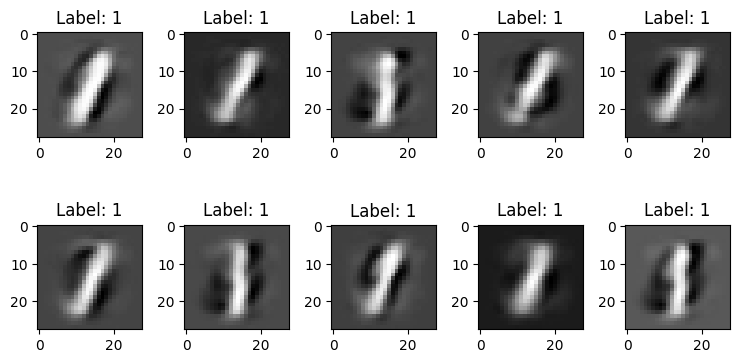

In [102]:
num_row = 2
num_col = 5  # plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(samples[i], cmap="gray")
    ax.set_title("Label: {}".format(1))
plt.tight_layout()
plt.show()

## Multivariate Conditional Transformation Models

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

In [103]:
def get_mctm_lambda(dims, M, thetas_constrain_fn):
    def lmbd(pv):
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)

        thetas = thetas_constrain_fn(tf.reshape(pv[..., : M * dims], shape))
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., M * dims :])

        mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)

        return tfd.TransformedDistribution(
            distribution=mv_normal,
            bijector=tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas)),
        )

    return lmbd

In [104]:
thetas_constrain_fn = get_thetas_constrain_fn(
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    eps=1e-04,
)

In [105]:
M = 20
output_shape = LATENTDIM * M + np.sum(np.arange(LATENTDIM + 1))

In [107]:
mctm_model = P(
    output_shape=output_shape,
    dist_lambda=get_mctm_lambda(LATENTDIM, M, thetas_constrain_fn),
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 hidden1 (Dense)             (None, 32)                64        
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 318)               10494     
                                                                 
 distribution_lambda_2 (Dist  ((None, 12),             0         
 ributionLambda)              (None, 12))                        
                                                                 
Total params: 11,614
Trainable params: 11,614
Non-trainable params: 0
_______________________________________________________

In [109]:
mctm_hist = fit_distribution(
    mctm_model,
    x=ds_train_encoded,
    #validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.1,
    lr_patience=2,
)

Epoch 1/100
469/469 [==============================] - 7s 7ms/step - loss: 156.7173 - lr: 0.1000
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 20.8749 - lr: 0.1000
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 20.1088 - lr: 0.1000
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 19.6912 - lr: 0.1000
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 19.4618 - lr: 0.1000
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 19.3304 - lr: 0.1000
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 19.3033 - lr: 0.1000
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 19.0823 - lr: 0.1000
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 18.9952 - lr: 0.1000
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 18.9365 - lr: 0.1000
Epoch 11/100
469/469 [================

In [111]:
mctm_samples = mctm_model(2.0 * tf.ones((1))).sample(10)
mctm_samples.shape

TensorShape([10, 1, 12])

In [114]:
samples = f(tf.squeeze(mctm_samples))

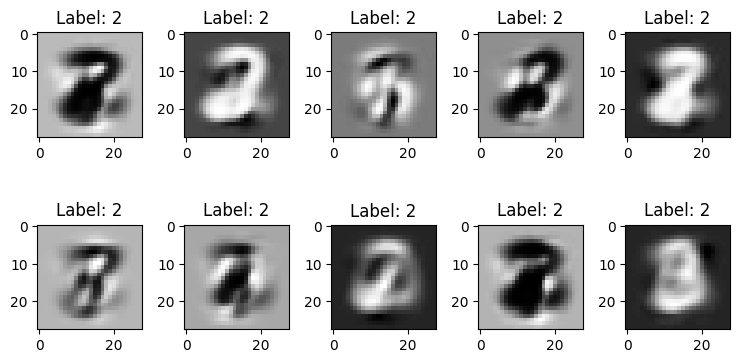

In [115]:
num_row = 2
num_col = 5  # plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(samples[i], cmap="gray")
    ax.set_title("Label: {}".format(2))
plt.tight_layout()
plt.show()

## MADE + BNF
https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

In [116]:
def get_bijector_fn(made, thetas_constrain_fn):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            dtype = made.dtype

            pvector = made(x, **kwds)
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [118]:
set_seed(1)
event_shape = (LATENTDIM,)
conditional_event_shape = (1,)

made = tfb.AutoregressiveNetwork(
    params=20,
    hidden_units=[32, 32],
    activation="relu",
    event_shape=event_shape,
    conditional=True,
    conditional_event_shape=conditional_event_shape,
)
thetas_constrain_fn = get_thetas_constrain_fn(low=-4, high=4, smooth_bounds=True)
bijector_fn = get_bijector_fn(made=made, thetas_constrain_fn=thetas_constrain_fn)
ar_mctm = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0, 1), sample_shape=[LATENTDIM]),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

In [ ]:
from tqdm.notebook import trange

epochs = 500
learning_rate = 0.01
decay_rate = 0.1

set_seed(1)

opt = tf.optimizers.Adam(learning_rate)

it = trange(epochs)
for i in it:
    nll = lambda: -ar_mctm.log_prob(
        train_y, bijector_kwargs={"conditional_input": train_x}
    )
    opt.minimize(nll, var_list=made.trainable_variables)
    it.set_postfix(loss=nll().numpy().mean(), lr=opt.learning_rate.numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

In [56]:
ar_mctm_samples = ar_mctm.sample((10, 1), bijector_kwargs={"conditional_input": val_x})
ar_mctm_samples.shape

TensorShape([10, 2186, 3])